# Descriptive Survival Analysis

This type of analytics answer the question "what has happened?"

# Packages

In [82]:
# ! pip install lifelines

In [67]:
import pandas as pd
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

# Introduction

In survival analysis the outcome is made of two variables, time and event. Sometimes such problems are broken down to sub-optimal problems such as regression on time or classification on event. That is why survival analysis is also considered as the superset of classification and regression.

Since the outcome has two variables, presentation of the outcome is either via survival or hazard functions. 


- In descriptive analytics, we focus on what has happened to the outcome y(time, event) 
- In predictive analytics, we predict what will happen to the outcome y(time, event) given the features x. 

# Survival function

The survival function $S(t)$, is defined as the probability that an event-of-interest occurs after a certain time $t$. 

$$
S(t) = P(T > t)
$$

where $T$ is the time at which the event occurs. 

**No Censoring**: If there are no censored observations, the most natural estimator for survival is the empirical estimator

$$
\hat S(t) = \frac{1}{n} \sum_{i=0}^n I(t_i > t)
$$

which is the proportion of the events observed after time $t$. 

**Censoring**: In presence of censoring, Kaplan and Meier (1958) proposed a nonparametric estimate of the survival function, which is the generalization of the empirical estimator for censored data


$$
\hat S(t) = \prod_{t_i<t} \hat S_i(t) 
$$
$$
\hat S_i(t) = 1 - \frac{d_i}{n_i} 
$$

Where $t_i$ is the observed event times, $d_i$ and $n_i$ are the number of events and subjects at risk at time $t_i$.

# Examples

## Example 1: KM curve with no censoring 
Consider the life of 10 light bulbs until they burn out

In [68]:
data = {
    'T': [3, 4, 4, 6, 7, 7, 8, 10, 11, 13],
    'E': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ], # due to no censoring, all events are 1 
}

df = pd.DataFrame(data)
df

,T,E
0,3,1
1,4,1
2,4,1
3,6,1
4,7,1
5,7,1
6,8,1
7,10,1
8,11,1
9,13,1


Text(0, 0.5, 'Survival Probability')

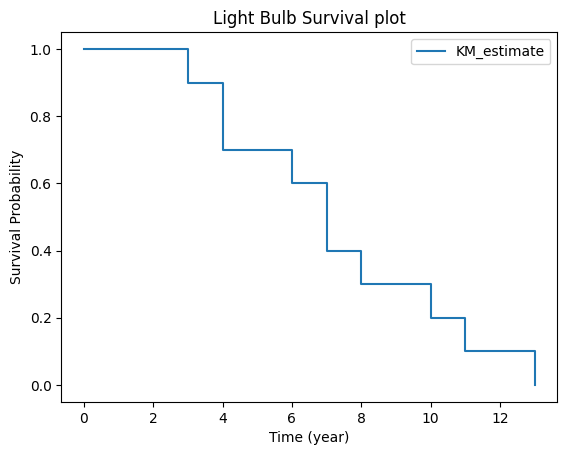

In [69]:
# Create KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df['T'], event_observed=df['E'])

# Plot the curve 
kmf.plot(ci_show=False)
plt.title('Light Bulb Survival plot')
plt.xlabel('Time (year)')
plt.ylabel('Survival Probability')

Interpretation: The probability that a light bulb survives longer than 8 year is 30%

Given 10 samples and no censoring, at every event occurence the curve drops 1/10. The underlying survival_function_ method confirms this.   


In [70]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.0
3.0,0.9
4.0,0.7
6.0,0.6
7.0,0.4
8.0,0.3
10.0,0.2
11.0,0.1
13.0,0.0


## Example 2: KM curve with censoring 

Let's consider the same example with 10 light bulbs, where some of them are not yet burned out or we have lost track of thier status(right-censoring)

In [71]:
data = {
    'T': [3, 4, 4, 6, 7, 7, 8, 10, 11, 13],
    'E': [1, 1, 0, 1, 1, 0, 1, 1, 1, 0],
}

df = pd.DataFrame(data)

Text(0, 0.5, 'Survival Probability')

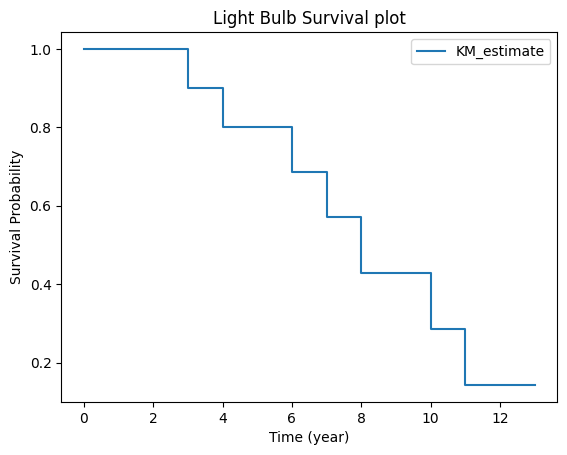

In [72]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df['T'], event_observed=df['E'])

kmf.plot(ci_show=False)
plt.title('Light Bulb Survival plot')
plt.xlabel('Time (year)')
plt.ylabel('Survival Probability')

In [73]:
kmf.survival_function_.reset_index()

,timeline,KM_estimate
0,0.0,1.000000
1,3.0,0.900000
2,4.0,0.800000
3,6.0,0.685714
4,7.0,0.571429
5,8.0,0.428571
6,10.0,0.285714
7,11.0,0.142857
8,13.0,0.142857


Let's see how the KM survival function S(t) is constructed from the KM curve table
t | d| c|n |S_i(t)| S(t) 
--|--|--|--|--|--|
0 | 0| 0|10|10/10 =1 | 1
3 | 1| 0|10|1-1/10 =9/10| 0.9
4 | 1| 1| 9|1-1/9 = 8/9 | 0.8
6 | 1| 0| 7|1-1/7 = 6/7 | 0.6857
7 | 1| 1| 6|1-1/6 = 5/6 | 0.5714
8 | 1| 0| 4|1-1/4 = 3/4 | 0.4285
10| 1| 0| 3|1-1/3 = 2/3 | 0.2857
11| 1| 0| 2|1-1/2 = 1/2 | 0.1428
13| 0| 1| 1|1-0/1 = 1   | 0.1428

## Example 3: Comparing Survival Curves


### Data:

The data is related to 432 convicts who were released from Maryland state prisons in the 1970s and who were followed up for one year after release. Half the released convicts were assigned at random to an experimental treatment in which they were given financial aid; half did not receive aid {cite}`rossi2013money`.

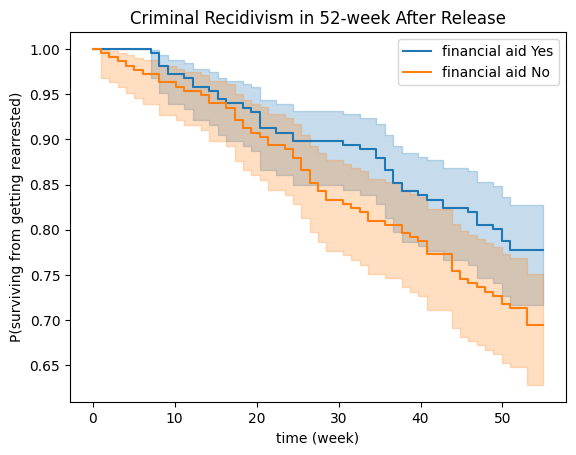

In [99]:
from lifelines.datasets import load_rossi
import numpy as np

# loading data 
data = load_rossi()
treat = data.query("fin == 1") 
ctrl = data.query("fin == 0")

# init & Fitting KM curves 
ax = plt.subplot()
t = np.linspace(0, 55, 55)
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf1.fit(treat['week'], treat['arrest'], timeline=t, label="financial aid Yes")
kmf2.fit(ctrl['week'], ctrl['arrest'], timeline=t, label="financial aid No")

# plotting the KM curves
kmf1.plot(ax=ax), kmf2.plot(ax=ax)
ax.set_title("Criminal Recidivism in 52-week After Release");
ax.set_ylabel("P(surviving from getting rearrested)");
ax.set_xlabel("time (week)");

### Statistical Significance 

Are these two curves statistically equivalent? To answer this question, we can use the log-rank test (Mantel 1966; Peto and Peto 1972). This is the most well-known and widely used method to test the null hypothesis of no difference in survival between two or more independent groups.

In [75]:

from lifelines.statistics import logrank_test
log_rank_test_result = logrank_test(
    treat['week'], 
    ctrl['week'], 
    event_observed_A=treat['arrest'], 
    event_observed_B=ctrl['arrest'],
)
print(f'p-value: {log_rank_test_result.p_value:.4f}')


p-value: 0.0501


```{note} 
* While `log-rank_test` function is used for two KM curves, `multivariate_logrank_test` can be used for more than 2 KM curves. 
* These methods also provide weightings for early vs late difference hypothesis testing
```

### Best practices for visualizing KM plots

In a recent survey from variety of stakeholders in healthcare, suggested that the addition of summary tables and confidence intervals greatly increased the effectiveness of Kaplan-Meier plots[article](https://pubmed.ncbi.nlm.nih.gov/31575572/)

The data is related to the life-span of political leaders in office. Event is triggered if leader is observed to have left office. Censoring happens when the leaders  died in office or were in office by 2008 (study finish time).

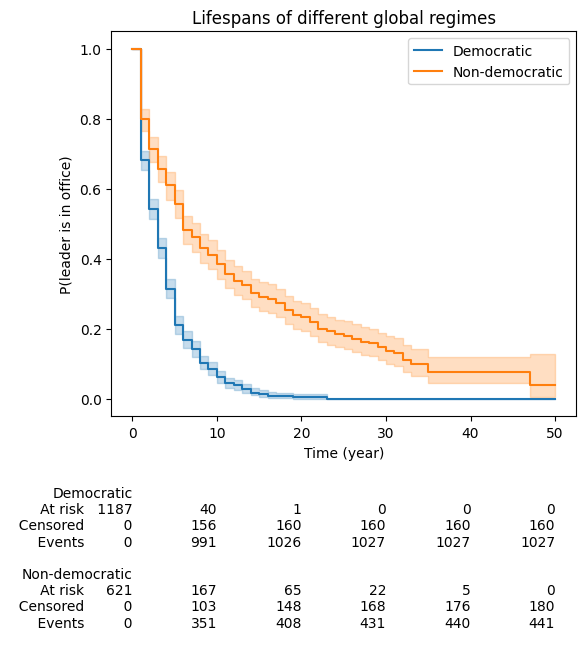

In [100]:
from lifelines.datasets import load_dd
from lifelines.plotting import add_at_risk_counts

data = load_dd()
kmf1, kmf2 = KaplanMeierFitter(), KaplanMeierFitter()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
t = np.linspace(0, 50, 51)

democracy = data.query("democracy == 'Democracy' ")
no_democracy = data.query("democracy == 'Non-democracy' ")

kmf1.fit(democracy['duration'], democracy['observed'], timeline=t, label="Democratic")
kmf2.fit(no_democracy['duration'], no_democracy['observed'], timeline=t, label="Non-democratic")

# Confidence Intervals 
kmf1.plot(ci_show=True, ax=ax), kmf2.plot(ci_show=True, ax=ax)
# Summary Tables 
add_at_risk_counts(kmf1, kmf2, ax=ax, fontsize=10, rows_to_show=["At risk", "Censored", "Events"])

ax.set_title("Lifespans of different global regimes");
ax.set_xlabel("Time (year)");
ax.set_ylabel("P(leader is in office)");

## Example 4: What is the objective of this visualization?

This is a real-world example from ABN AMRO which will be shown in the presentation deck due to data sensitivity 

# Exercises

## Exercise 1: What is strange in this visualization?

This is a real-world example from ABN AMRO which will be shown in the presentation deck due to data sensitivity 

## Exercise 2: Exploratory Data Analysis

### Data

The data comes from German Breast Cancer Study Group, where in Randomized 2 x 2 clinical trial was aiming to evaluate hormonal treatment and the duration of chemotherapy in node-positive breast cancer patients {cite}`schumacher1994randomized`

- horTh: hormonal therapy, a factor at two levels no and yes.


- age: of the patients in years.
- menostat: 0 menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- tsize: tumor size (in mm).
- tgrade: tumor grade, a ordered factor at levels I < II < III.
- pnodes: number of positive nodes.
- progrec: progesterone receptor (in fmol).
- estrec: estrogen receptor (in fmol).
- time: recurrence free survival time (in days).
- cens: censoring indicator (0- censored, 1- event).

*Recurrence Free Survival: defined as the length of time from the end of primary treatment (Surgery/chemotherapy) until there is evidence of cancer recurrence or until the death of the patient.*

In [78]:
from lifelines.datasets import load_gbsg2
df = load_gbsg2()
df

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1
...,...,...,...,...,...,...,...,...,...,...
681,no,49,Pre,30,III,3,1,84,721,0
682,yes,53,Post,25,III,17,0,0,186,0
683,no,51,Pre,25,III,5,43,0,769,1
684,no,52,Post,23,II,3,15,34,727,1


### Exercise 2.1: 
- What is the impact of hormonal therapy on brest cancer survival? (Visualize KM survival curves for patients with and without therapy following best practices)
- Does hormonal therapy provide a significant impact? (guide: use log-rank test)


### Exercse 2.2: 
- What is the impact of number of positive nodes on patients survival without therapy? (guide: visualize KM curves for number of equally sized bins )

### Exercise 2.3:

- What is the generic effect of tumor size grade (`tgrade`) on patient survival without therapy?
- Does the tumor size grade correlate significantly with patient survival? (log-rank test)

# Summary & Takeaways

* If there are no censored observations and all subjects die KM-curve reaches zero, otherwise to the fraction of subjects that survived. 
* If the data for any subjetake acts are censored, the bottom point on the survival curve will not equal the fraction of subjects that survived. [link for further reading](https://www.graphpad.com/support/faq/what-determines-how-low-a-kaplan-meier-survival-curve-ends-up-at-late-time-points/#:~:text=If%20there%20are%20no%20censored,the%20percent%20survival%20is%20zero.)

* If the survival curve goes all the way down to zero, that does not mean that every subject in the study died and some could be probably censored. 